In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
import datetime
import warnings
import numpy as np
from time import time
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
# read data

df = pd.read_pickle('../pkl_data_2/merged_data.pkl')
df.index = df.index.set_levels([df.index.levels[0], pd.to_datetime(df.index.levels[1],format='%Y%m%d'), df.index.levels[2]])
df.sort_index(level=['ann_date'],inplace=True)
df.head()

-30       -29       -28       -27  \
ticker ann_date   quarternum                                           
KEY    1993-10-15 3           0.875159  0.880255  0.876433  0.876433   
       1994-01-21 1           1.138627  1.114401  1.153432  1.150740   
CCK    1995-10-18 3           0.771429  0.757147  0.771429  0.771429   
F      1996-01-31 1           0.937453  0.930725  0.943932  0.946923   
NOVL   1996-02-21 1           0.965263  0.966316  0.949474  0.995789   

                                   -26       -25       -24       -23  \
ticker ann_date   quarternum                                           
KEY    1993-10-15 3           0.896815  0.910828  0.929936  0.908280   
       1994-01-21 1           1.141319  1.119785  1.126514  1.149394   
CCK    1995-10-18 3           0.771429  0.771429  0.771429  0.771429   
F      1996-01-31 1           0.960877  0.964366  0.963369  0.966110   
NOVL   1996-02-21 1           0.965263  0.972632  0.980000  0.991579   

                                   -22       -21  ...  ern_date  \
ticker ann_date   quarternum                      ...             
KEY    1993-10-15 3           0.942675  0.960510  ...  19930930   
       1994-01-21 1           1.177658  1.183042  ...  19931231   
CCK    1995-10-18 3           0.785719  0.828571  ...  19950930   
F      1996-01-31 1           0.948168  0.959382  ...  19951231   
NOVL   1996-02-21 1           0.970526  0.983158  ...  19960131   

                              actual_ern_value  median_surprise  \
ticker ann_date   quarternum                                      
KEY    1993-10-15 3                       0.97              NaN   
       1994-01-21 1                       1.01              NaN   
CCK    1995-10-18 3                       0.38         6.717514   
F      1996-01-31 1                       0.29        19.014636   
NOVL   1996-02-21 1                       0.17              NaN   

                              mean_surprise  forecast_skew  forecast_kurt  \
ticker ann_date   quarternum                                                
KEY    1993-10-15 3                     NaN            NaN            NaN   
       1994-01-21 1                     NaN            NaN            NaN   
CCK    1995-10-18 3                6.717514            0.0       0.707107   
F      1996-01-31 1               19.014636            0.0       0.000000   
NOVL   1996-02-21 1                     NaN            NaN            NaN   

                                   std  filled_std  forecast_count  \
ticker ann_date   quarternum                                         
KEY    1993-10-15 3                NaN         NaN             1.0   
       1994-01-21 1                NaN         NaN             1.0   
CCK    1995-10-18 3           0.056569    0.056569             2.0   
F      1996-01-31 1                NaN    0.008415             1.0   
NOVL   1996-02-21 1                NaN         NaN             1.0   

                              forecast_range  
ticker ann_date   quarternum                  
KEY    1993-10-15 3                     0.00  
       1994-01-21 1                     0.00  
CCK    1995-10-18 3                     0.08  
F      1996-01-31 1                     0.00  
NOVL   1996-02-21 1                     0.00  

[5 rows x 72 columns]

In [3]:
# build target variable

q_10 = df[10].quantile(0.1)
q_90 = df[10].quantile(0.9)

#t_bottom = lambda x: 0 if (x>q_10) else -1
#t_top = lambda x: 0 if (x<q_90) else 1

t = lambda x: 1 if (x>q_90) else (1 if (x<q_10) else 0)

#df['y_top'] = [t_top(df[10][i]) for i in range(len(df[10]))]
#df['y_bottom'] = [t_bottom(df[10][i]) for i in range(len(df[10]))]

df['y'] = [t(df[10][i]) for i in range(len(df[10]))]

print('target variable y has',df['y'].value_counts()[0],'occurences of 0,',df['y'].value_counts()[1],'occurences of 1 ')
#print('target variable y_top has',df['y_top'].value_counts()[0],'occurences of 0 and',df['y_top'].value_counts()[1],'occurences of 1')
#print('target variable y_bottom has',df['y_bottom'].value_counts()[0],'occurences of 0 and',df['y_bottom'].value_counts()[-1],'occurences of -1')

target variable y has 665 occurences of 0, 168 occurences of 1 


In [4]:
# types of training datasets 

type_1 = ['median_surprise', 'mean_surprise', 'forecast_skew', 'forecast_kurt','y']
type_2 = ['forecast_count','std','forecast_range','actual_ern_value','y']

In [5]:
# some useful functions

def tq(year):
    
    # obtains available quarter for that year
    
    t = df.iloc[df.index.get_level_values('ann_date') <= str(year)+'-12-31']
    t = t.iloc[t.index.get_level_values('ann_date') >= str(year)+'-01-01']
    return t.index.get_level_values('quarternum').tolist()

def _idx(year,tested_quarter):
    
    # idx is the test set size <=> number of earnings in this year for this tested_quarter
    
    t = df.iloc[df.index.get_level_values('ann_date') <= str(year)+'-12-31']
    t = t.iloc[t.index.get_level_values('ann_date') >= str(year)+'-01-01']
    return t.iloc[t.index.get_level_values('quarternum') == tested_quarter].shape[0]

In [6]:
# pipeline

class DataFrameSelector(BaseEstimator, TransformerMixin):
    #
    # selects features from df
    #
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]
        
    
class QuarterSelector(BaseEstimator, TransformerMixin):
    #
    # selects all data available on or before year, tested quarter from df
    #
    def __init__(self, year, tested_quarter):
        self.year = year
        self.tested_quarter = tested_quarter
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        t = X.iloc[df.index.get_level_values('ann_date') <= str(self.year)+'-12-31']
        fdate = t.iloc[t.index.get_level_values('ann_date') >= str(self.year)+'-01-01']
        fdate = fdate.iloc[fdate.index.get_level_values('quarternum') == self.tested_quarter]
        fdate = fdate.index.get_level_values('ann_date')[-1]
        
        return t.iloc[t.index.get_level_values('ann_date') <= fdate]
        
    
class TrainSelector(BaseEstimator, TransformerMixin):
    #
    # selects training data
    #
    def __init__(self, year, tested_quarter):
        self.year = year
        self.tested_quarter = tested_quarter
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        idx = _idx(self.year,self.tested_quarter)
        return X.iloc[:-idx,:]
    
class TestSelector(BaseEstimator, TransformerMixin):
    #
    # selects training data
    #
    def __init__(self, year, tested_quarter):
        self.year = year
        self.tested_quarter = tested_quarter
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        idx = _idx(self.year,self.tested_quarter)
        return X.iloc[-idx:,:]
    

In [7]:
def run(df,_type,year,tested_quarter):    
#def run(df,_type,year,tested_quarter,SGDargs):
    
    
    if _type == '1':
        
        train_pipeline = Pipeline([
                ('qt_selector',QuarterSelector(year,tested_quarter)),
                ('train_selector',TrainSelector(year,tested_quarter)),
                ('ft_selector',DataFrameSelector(type_1)),
                ('imputer',SimpleImputer(strategy="median"))])
        
        test_pipeline = Pipeline([
                ('qt_selector',QuarterSelector(year,tested_quarter)),
                ('test_selector',TrainSelector(year,tested_quarter)),
                ('ft_selector',DataFrameSelector(type_1)),
                ('imputer',SimpleImputer(strategy="median"))])
    else:
        train_pipeline = Pipeline([
                ('qt_selector',QuarterSelector(year,tested_quarter)),
                ('train_selector',TrainSelector(year,tested_quarter)),
                ('ft_selector',DataFrameSelector(type_2)),
                ('imputer',SimpleImputer(strategy="median"))])

        test_pipeline = Pipeline([
                ('qt_selector',QuarterSelector(year,tested_quarter)),
                ('test_selector',TrainSelector(year,tested_quarter)),
                ('ft_selector',DataFrameSelector(type_2)),
                ('imputer',SimpleImputer(strategy="median"))])
        
                
    train = train_pipeline.fit_transform(df)
    test = test_pipeline.fit_transform(df)

    # separate features and target variable
    X_train = train[:,:-1]
    X_test = test[:,:-1]
    y_train = train[:,-1]
    y_test = test[:,-1]
        
    return [X_train,y_train,X_test,y_test]
        
    

In [8]:
def GridSearch(dataset_type,_param_grid):
    
    # store result
    best_f1 = []
    
    # keep track of time
    start = time()
    
    for year in [1995+i for i in range(34)]:
        v = True
        for tested_quarter in tq(year):


            # feature engineering for the desired settings
            X_train,y_train,X_test,y_test = run(df,dataset_type,year,tested_quarter)

            # define gridsearch
            gsc = GridSearchCV(
                    estimator=SGDClassifier(),
                    param_grid=_param_grid,
                    scoring=metrics.make_scorer(metrics.f1_score),
                    cv = 2,
                    verbose=0, 
                    n_jobs=-1)

            try:
                # proceed to search
                grid_result = gsc.fit(X_train, y_train)

                # store best parameters
                best_params = grid_result.best_params_
                

                # build model with best params
                logit_clf = SGDClassifier(random_state = best_params['random_state'],
                                  loss = best_params['loss'],
                                  class_weight = best_params['class_weight'],
                                  max_iter = best_params['max_iter'], 
                                  tol = best_params['tol'],
                                  alpha = best_params['alpha'])

                logit_clf.fit(X_train, y_train)
                p = logit_clf.predict(X_train)
                best_f1.append(metrics.f1_score(y_train.tolist(),p))
                
                if v:
                    print('proceeded to search for year',year)
                    v=False

            except:
                print('[Exception]  couldn\'t predict for year',year,' quarter',tested_quarter)

    print('total time elapsed:',int(time()-start),'s')
    return best_f1
    

# Dataset type 1

## log loss

In [40]:
# define grid search parameters

_param_grid_log_type1={
'random_state':[42],
'loss':['log'],
'class_weight':[{0:0.1,1:1}],
'max_iter': [10,50,100],
'tol': np.linspace(1e-12,1e-7,5),
'alpha': np.linspace(1e-3,1e-2,5)}

In [41]:
# proceed to search and store best F1 scores achieved on training set

best_f1_log_1 = GridSearch(dataset_type='1',_param_grid = _param_grid_log_type1)

[Exception]  couldn't predict for year 1995  quarter 3
[Exception]  couldn't predict for year 1996  quarter 1
[Exception]  couldn't predict for year 1996  quarter 1
proceeded to search for year 1996
proceeded to search for year 1997
proceeded to search for year 1998
proceeded to search for year 1999
proceeded to search for year 2000
proceeded to search for year 2001
proceeded to search for year 2002
proceeded to search for year 2003
proceeded to search for year 2004
proceeded to search for year 2005
proceeded to search for year 2006
proceeded to search for year 2007
proceeded to search for year 2008
proceeded to search for year 2009
proceeded to search for year 2010
proceeded to search for year 2011
proceeded to search for year 2012
proceeded to search for year 2013
proceeded to search for year 2014
proceeded to search for year 2015
proceeded to search for year 2016
total time elapsed: 399 s


## hinge loss

In [42]:
# define grid search parameters

_param_grid_hinge_type1={
'random_state':[42],
'loss':['hinge'],
'class_weight':[{0:0.1,1:1}],
'max_iter': [10,50,100],
'tol': np.linspace(1e-12,1e-7,5),
'alpha': np.linspace(1e-3,1e-2,5)}

In [43]:
# proceed to search and store best F1 scores achieved on training set

best_f1_hinge_1 = GridSearch(dataset_type='1',_param_grid = _param_grid_hinge_type1)

[Exception]  couldn't predict for year 1995  quarter 3
[Exception]  couldn't predict for year 1996  quarter 1
[Exception]  couldn't predict for year 1996  quarter 1
proceeded to search for year 1996
proceeded to search for year 1997
proceeded to search for year 1998
proceeded to search for year 1999
proceeded to search for year 2000
proceeded to search for year 2001
proceeded to search for year 2002
proceeded to search for year 2003
proceeded to search for year 2004
proceeded to search for year 2005
proceeded to search for year 2006
proceeded to search for year 2007
proceeded to search for year 2008
proceeded to search for year 2009
proceeded to search for year 2010
proceeded to search for year 2011
proceeded to search for year 2012
proceeded to search for year 2013
proceeded to search for year 2014
proceeded to search for year 2015
proceeded to search for year 2016
total time elapsed: 318 s


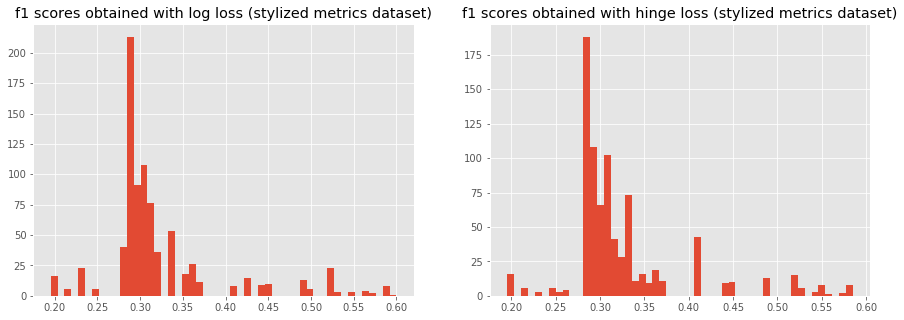

In [44]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(best_f1_log_1,bins=50)
plt.title('f1 scores obtained with log loss (stylized metrics dataset)')
plt.subplot(1,2,2)
plt.hist(best_f1_hinge_1,bins=50)
plt.title('f1 scores obtained with hinge loss (stylized metrics dataset)')
fig.savefig('../images/F1_dataset1.png', dpi=fig.dpi)
plt.show()

# Dataset type 2

## log loss

In [45]:
# define grid search parameters

_param_grid_log_type2={
'random_state':[42],
'loss':['log'],
'class_weight':[{0:0.1,1:1}],
'max_iter': [10,50,100],
'tol': np.linspace(1e-12,1e-7,5),
'alpha': np.linspace(1e-3,1e-2,5)}

In [46]:
# proceed to search and store best F1 scores achieved on training set

best_f1_log_2 = GridSearch(dataset_type='2',_param_grid = _param_grid_log_type2)

[Exception]  couldn't predict for year 1995  quarter 3
[Exception]  couldn't predict for year 1996  quarter 1
[Exception]  couldn't predict for year 1996  quarter 1
proceeded to search for year 1996
proceeded to search for year 1997
proceeded to search for year 1998
proceeded to search for year 1999
proceeded to search for year 2000
proceeded to search for year 2001
proceeded to search for year 2002
proceeded to search for year 2003
proceeded to search for year 2004
proceeded to search for year 2005
proceeded to search for year 2006
proceeded to search for year 2007
proceeded to search for year 2008
proceeded to search for year 2009
proceeded to search for year 2010
proceeded to search for year 2011
proceeded to search for year 2012
proceeded to search for year 2013
proceeded to search for year 2014
proceeded to search for year 2015
proceeded to search for year 2016
total time elapsed: 330 s


## hinge loss

In [47]:
# define grid search parameters

_param_grid_hinge_type2={
'random_state':[42],
'loss':['hinge'],
'class_weight':[{0:0.1,1:1}],
'max_iter': [500,750],
'tol': np.linspace(1e-7,1e-5,5),
'alpha': np.linspace(1e-3,1e-2,5)}

In [48]:
# proceed to search and store best F1 scores achieved on training set

best_f1_hinge_2 = GridSearch(dataset_type='2',_param_grid = _param_grid_hinge_type2)

[Exception]  couldn't predict for year 1995  quarter 3
[Exception]  couldn't predict for year 1996  quarter 1
[Exception]  couldn't predict for year 1996  quarter 1
proceeded to search for year 1996
proceeded to search for year 1997
proceeded to search for year 1998
proceeded to search for year 1999
proceeded to search for year 2000
proceeded to search for year 2001
proceeded to search for year 2002
proceeded to search for year 2003
proceeded to search for year 2004
proceeded to search for year 2005
proceeded to search for year 2006
proceeded to search for year 2007
proceeded to search for year 2008
proceeded to search for year 2009
proceeded to search for year 2010
proceeded to search for year 2011
proceeded to search for year 2012
proceeded to search for year 2013
proceeded to search for year 2014
proceeded to search for year 2015
proceeded to search for year 2016
total time elapsed: 232 s


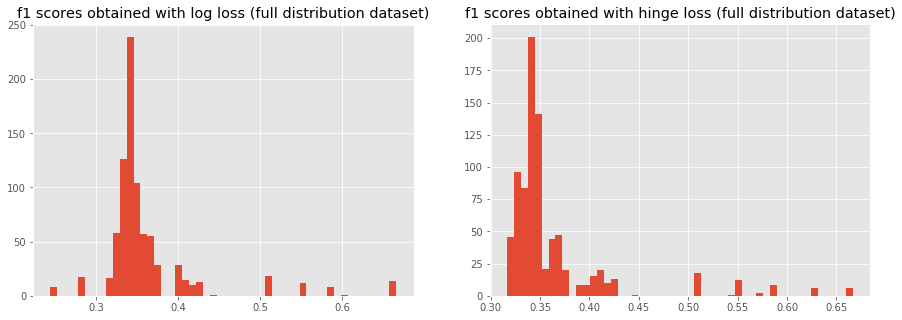

In [49]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(best_f1_log_2,bins=50)
plt.title('f1 scores obtained with log loss (full distribution dataset)')
plt.subplot(1,2,2)
plt.hist(best_f1_hinge_2,bins=50)
plt.title('f1 scores obtained with hinge loss (full distribution dataset)')
fig.savefig('../images/F1_dataset2.png', dpi=fig.dpi)
plt.show()

# Precision-Recall curves

- stylized metrics dataset with log loss:

No Skill: f1=0.000 auc=0.603
Logistic: f1=0.291 auc=0.392


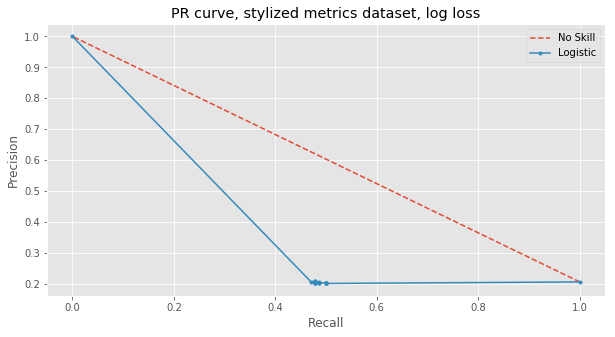

In [30]:
# feature engineering for the desired settings
X_train,Y_train,X_test,Y_test = run(df,'1',2014,1)

# define gridsearch
gsc = GridSearchCV(
        estimator=SGDClassifier(),
        param_grid=_param_grid_log_type1,
        scoring=metrics.make_scorer(metrics.f1_score),
        cv = 2,
        verbose=0, 
        n_jobs=-1)

# proceed to search
grid_result = gsc.fit(X_train, Y_train)

# store best parameters
best_params = grid_result.best_params_


# build model with best params
logit_clf = SGDClassifier(random_state = best_params['random_state'],
                  loss = best_params['loss'],
                  class_weight = best_params['class_weight'],
                  max_iter = best_params['max_iter'], 
                  tol = best_params['tol'],
                  alpha = best_params['alpha'])

logit_clf.fit(X_train, Y_train)
                  

# predict class values
yhat = logit_clf.predict(X_train)

# calculate precision and recall for each threshold
ns_probs = [0 for i in range(len(yhat))]
lr_probs = logit_clf.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
ns_precision, ns_recall, _ = metrics.precision_recall_curve(Y_train, ns_probs)
lr_precision, lr_recall, _ = metrics.precision_recall_curve(Y_train, lr_probs)

# calculate scores
ns_f1, ns_auc = metrics.f1_score(Y_train, ns_probs), metrics.auc(ns_recall, ns_precision)
lr_f1, lr_auc = metrics.f1_score(Y_train, yhat), metrics.auc(lr_recall, lr_precision)

# summarize scores
print('No Skill: f1=%.3f auc=%.3f' % (ns_f1, ns_auc))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
fig = plt.figure(figsize=(10,5))
plt.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve, stylized metrics dataset, log loss')
plt.legend()
plt.show()
fig.savefig('../images/PR_log_1.png', dpi=fig.dpi)

- stylized metrics dataset with hinge loss:

No Skill: f1=0.000 auc=0.603
Logistic: f1=0.291 auc=0.603


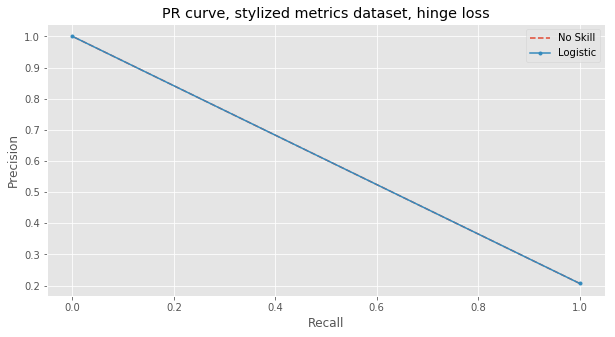

In [31]:
# feature engineering for the desired settings
X_train,Y_train,X_test,Y_test = run(df,'1',2014,1)

# define gridsearch
gsc = GridSearchCV(
        estimator=SGDClassifier(),
        param_grid=_param_grid_hinge_type1,
        scoring=metrics.make_scorer(metrics.f1_score),
        cv = 2,
        verbose=0, 
        n_jobs=-1)

# proceed to search
grid_result = gsc.fit(X_train, Y_train)

# store best parameters
best_params = grid_result.best_params_

# build model with best params
logit_clf = SGDClassifier(random_state = best_params['random_state'],
                  loss = best_params['loss'],
                  class_weight = best_params['class_weight'],
                  max_iter = best_params['max_iter'], 
                  tol = best_params['tol'],
                  alpha = best_params['alpha'])

logit_clf.fit(X_train, Y_train)
                  

# predict class values
yhat = logit_clf.predict(X_train)

# calculate precision and recall for each threshold
ns_probs = [0 for i in range(len(yhat))]
calibrator = CalibratedClassifierCV(logit_clf, cv='prefit')
model=calibrator.fit(X_train, Y_train)
lr_probs = model.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
ns_precision, ns_recall, _ = metrics.precision_recall_curve(Y_train, ns_probs)
lr_precision, lr_recall, _ = metrics.precision_recall_curve(Y_train, lr_probs)

# calculate scores
ns_f1, ns_auc = metrics.f1_score(Y_train, ns_probs), metrics.auc(ns_recall, ns_precision)
lr_f1, lr_auc = metrics.f1_score(Y_train, yhat), metrics.auc(lr_recall, lr_precision)

# summarize scores
print('No Skill: f1=%.3f auc=%.3f' % (ns_f1, ns_auc))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
fig = plt.figure(figsize=(10,5))
plt.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve, stylized metrics dataset, hinge loss')
plt.legend()
plt.show()
fig.savefig('../images/PR_hinge_1.png', dpi=fig.dpi)

- full distribution dataset with log loss:

No Skill: f1=0.000 auc=0.603
Logistic: f1=0.343 auc=0.248


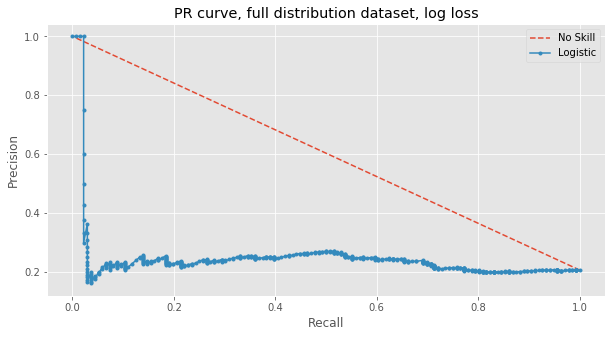

In [32]:
# feature engineering for the desired settings
X_train,Y_train,X_test,Y_test = run(df,'2',2014,1)

# define gridsearch
gsc = GridSearchCV(
        estimator=SGDClassifier(),
        param_grid=_param_grid_log_type2,
        scoring=metrics.make_scorer(metrics.f1_score),
        cv = 2,
        verbose=0, 
        n_jobs=-1)

# proceed to search
grid_result = gsc.fit(X_train, Y_train)

# store best parameters
best_params = grid_result.best_params_

# build model with best params
logit_clf = SGDClassifier(random_state = best_params['random_state'],
                  loss = best_params['loss'],
                  class_weight = best_params['class_weight'],
                  max_iter = best_params['max_iter'], 
                  tol = best_params['tol'],
                  alpha = best_params['alpha'])

logit_clf.fit(X_train, Y_train)
                  

# predict class values
yhat = logit_clf.predict(X_train)

# calculate precision and recall for each threshold
ns_probs = [0 for i in range(len(yhat))]
lr_probs = logit_clf.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
ns_precision, ns_recall, _ = metrics.precision_recall_curve(Y_train, ns_probs)
lr_precision, lr_recall, _ = metrics.precision_recall_curve(Y_train, lr_probs)

# calculate scores
ns_f1, ns_auc = metrics.f1_score(Y_train, ns_probs), metrics.auc(ns_recall, ns_precision)
lr_f1, lr_auc = metrics.f1_score(Y_train, yhat), metrics.auc(lr_recall, lr_precision)

# summarize scores
print('No Skill: f1=%.3f auc=%.3f' % (ns_f1, ns_auc))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
fig = plt.figure(figsize=(10,5))
plt.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve, full distribution dataset, log loss')
plt.legend()
plt.show()
fig.savefig('../images/PR_log_2.png', dpi=fig.dpi)

- full distribution dataset with hinge loss:

No Skill: f1=0.000 auc=0.603
Logistic: f1=0.343 auc=0.277


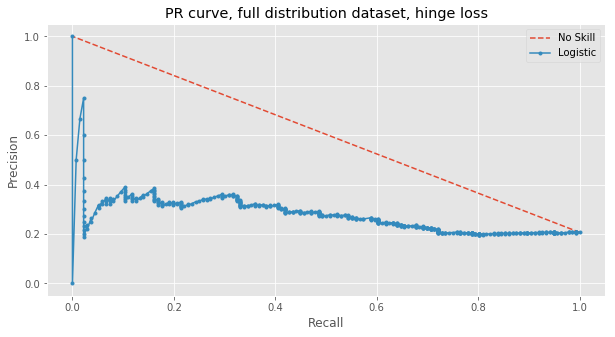

In [33]:
# feature engineering for the desired settings
X_train,Y_train,X_test,Y_test = run(df,'2',2014,1)

# define gridsearch
gsc = GridSearchCV(
        estimator=SGDClassifier(),
        param_grid=_param_grid_hinge_type2,
        scoring=metrics.make_scorer(metrics.f1_score),
        cv = 2,
        verbose=0, 
        n_jobs=-1)

# proceed to search
grid_result = gsc.fit(X_train, Y_train)

# store best parameters
best_params = grid_result.best_params_

# build model with best params
logit_clf = SGDClassifier(random_state = best_params['random_state'],
                  loss = best_params['loss'],
                  class_weight = best_params['class_weight'],
                  max_iter = best_params['max_iter'], 
                  tol = best_params['tol'],
                  alpha = best_params['alpha'])

logit_clf.fit(X_train, Y_train)
                  

# predict class values
yhat = logit_clf.predict(X_train)

# calculate precision and recall for each threshold
ns_probs = [0 for i in range(len(yhat))]
calibrator = CalibratedClassifierCV(logit_clf, cv='prefit')
model=calibrator.fit(X_train, Y_train)
lr_probs = model.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
ns_precision, ns_recall, _ = metrics.precision_recall_curve(Y_train, ns_probs)
lr_precision, lr_recall, _ = metrics.precision_recall_curve(Y_train, lr_probs)

# calculate scores
ns_f1, ns_auc = metrics.f1_score(Y_train, ns_probs), metrics.auc(ns_recall, ns_precision)
lr_f1, lr_auc = metrics.f1_score(Y_train, yhat), metrics.auc(lr_recall, lr_precision)

# summarize scores
print('No Skill: f1=%.3f auc=%.3f' % (ns_f1, ns_auc))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
plt.figure(figsize=(10,5))
plt.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve, full distribution dataset, hinge loss')
plt.legend()
plt.show()
fig.savefig('../images/PR_hinge_2.png', dpi=fig.dpi)